### Imports

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
%run parse.py
from mpl_toolkits.mplot3d import Axes3D

### Load data from Bigquery

In [2]:
table = 'eth-tokens.test.clean_avg_with_balances_tokens'
label_table = 'eth-tokens.alldata.etherscan_labelcloud'

In [3]:
sql = '''
SELECT *  FROM `{}`
'''.format(table)

df = client.query(sql).to_dataframe()

In [4]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [5]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [6]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)

#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)




/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


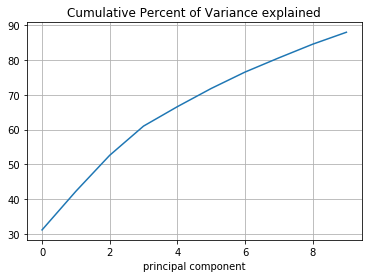

In [49]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

### Choose number of clusters with Calinski-Harabaz, Elbow Plot

Text(0.5,1,'Calinski Harabaz Scores')

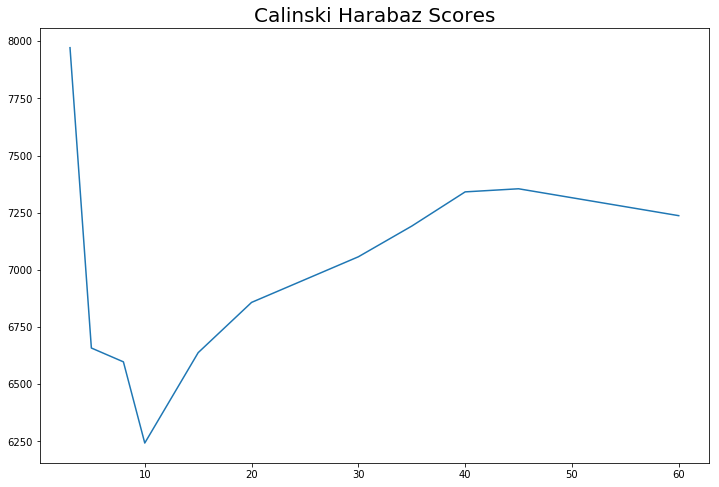

In [7]:
#scoring metric?
fig = plt.figure(figsize=(12,8))
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [3,5,8,10,15,20,30,35,40,45,60]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores', fontsize=20)

Text(0,0.5,'within cluster sum of squares')

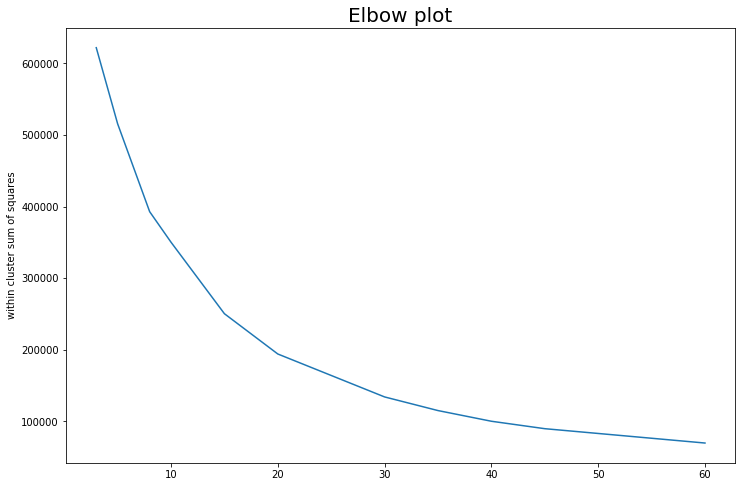

In [8]:
#elbow plot
fig = plt.figure(figsize=(12,8))
plt.plot(clusters,inertias)
plt.title('Elbow plot',fontsize=20)
plt.ylabel('within cluster sum of squares')

## Optimal clusters

In [95]:
#optimal number of clusters is around 40
cl = KMeans(40)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=40, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [53]:
# %run silhouette_plotter.py
# X=results
# range_n_clusters = [20]
# if len(newresults) <20000:
#     silhouette_plotter(X, range_n_clusters)

In [97]:
#subset results for tsne
#address mask needed for later superposition
max_size = len(results)
subset_results = []
lbls = []
address_mask = np.array([False for addr in df['address']]) 
for c in np.unique(cl.labels_):
    mask = (cl.labels_==c)
    c_size = np.sum(mask)
    if c_size < max_size:
        lbls.extend(list(cl.labels_[cl.labels_==c]))
        subset_results.append(results[mask])
        address_mask |= mask
lbls=np.array(lbls)
subset_results=np.vstack(subset_results)

In [55]:
# #not using subset
# subset_results = results
# lbls = cl.labels_

In [56]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(subset_results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 35917 samples in 0.019s...
[t-SNE] Computed neighbors for 35917 samples in 2.764s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35917
[t-SNE] Computed conditional probabilities for sample 2000 / 35917
[t-SNE] Computed conditional probabilities for sample 3000 / 35917
[t-SNE] Computed conditional probabilities for sample 4000 / 35917
[t-SNE] Computed conditional probabilities for sample 5000 / 35917
[t-SNE] Computed conditional probabilities for sample 6000 / 35917
[t-SNE] Computed conditional probabilities for sample 7000 / 35917
[t-SNE] Computed conditional probabilities for sample 8000 / 35917
[t-SNE] Computed conditional probabilities for sample 9000 / 35917
[t-SNE] Computed conditional probabilities for sample 10000 / 35917
[t-SNE] Computed conditional probabilities for sample 11000 / 35917
[t-SNE] Computed conditional probabilities for sample 12000 / 35917
[t-SNE] Computed conditional probabilities for sa

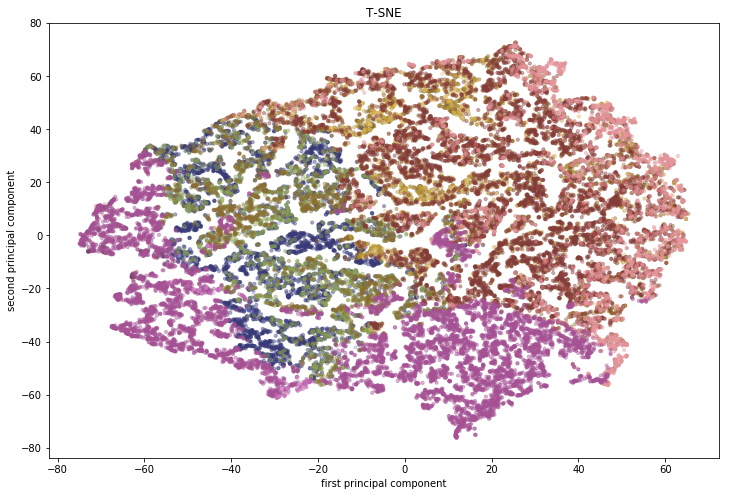

In [98]:
#color coded by cluster
plt.figure(figsize=(12,8))

plt.scatter(tsne_results[:,0], tsne_results[:,1], s=10,c=lbls,cmap='tab20b', alpha=.4)


# leg = plt.legend()




# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

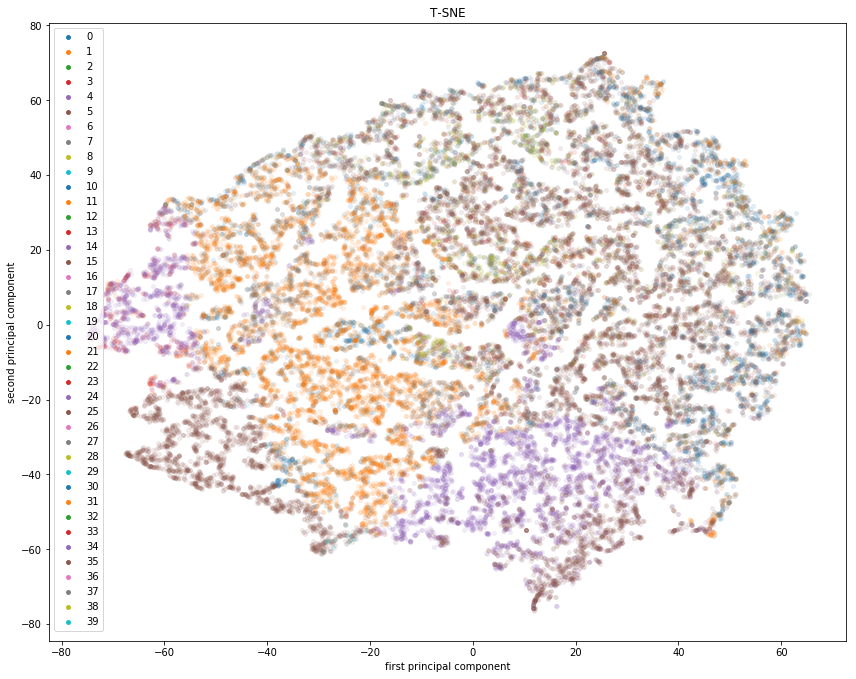

In [100]:

plt.figure(figsize=(12,10))
for c in np.unique(lbls):
    mask = lbls==c
    if np.sum(mask) <0:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=15,alpha=.1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.tight_layout()

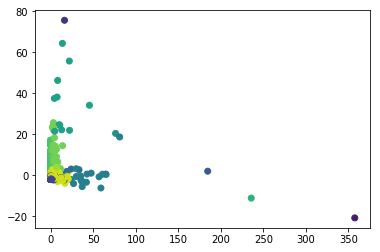

In [59]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

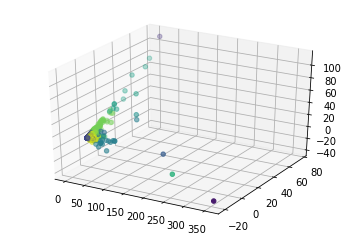

In [60]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)

## Label centroids with cluster

In [61]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = scale.inverse_transform(pca.inverse_transform(c))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [62]:
#put cluster sizes into summary dataframe
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [63]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
3,2.482877e+02,-3.505887e+02,-1.320290e+03,56.480036,7.216947e+05,3.466110e+04,3.312197e+03,43.944950,2.239799e+06,5.175290e+04,...,2.715573e+05,9.122056,-1.505802e+01,7.250952e+05,1.115875e+06,1.098686e+06,1.474351e+06,10.062341,3.492438e+02,17103
0,-8.431789e+01,2.154496e+01,1.558919e+03,61.631391,-5.861631e+05,2.593993e+04,2.085529e+03,119.172514,-3.453782e+05,2.457914e+04,...,-2.840177e+04,-9.447717,-3.912156e+01,2.717430e+06,4.106930e+06,3.159885e+06,4.341511e+06,16.677414,2.338016e+02,9679
13,2.935901e+03,3.283834e+03,3.313523e+04,113.655414,7.268334e+06,2.840738e+04,1.769324e+04,211.230513,2.383883e+06,2.257293e+04,...,2.635881e+04,-2.639638,2.835298e+02,8.345038e+05,1.656636e+06,1.059022e+06,1.898489e+06,39.943018,1.533037e+03,5202
14,2.458810e+02,1.134428e+02,-5.957349e+03,91.766462,2.666605e+06,2.536051e+04,4.033773e+02,172.517961,2.668395e+06,9.947061e+03,...,1.371316e+05,12.159661,2.361228e+02,2.287964e+06,3.730035e+06,9.417198e+06,1.250946e+07,12.649719,9.493197e+02,2270
10,-2.683098e+02,-1.540935e+02,-2.411106e+03,85.868065,3.353911e+06,3.120765e+04,-8.860994e+02,319.669668,2.271385e+06,2.746857e+04,...,9.723456e+04,-14.590749,2.802198e+02,9.765031e+06,1.405475e+07,3.933959e+06,5.489581e+06,15.227906,2.128040e+02,1522
11,4.078241e+03,-8.143276e+02,2.699631e+05,8167.391704,7.730781e+07,2.116032e+06,1.250507e+05,10927.740556,4.227889e+07,2.393125e+06,...,4.238246e+06,2293.506963,2.336089e+03,3.236690e+06,4.782915e+06,2.650177e+06,4.018291e+06,34.468734,6.207511e+04,102
6,4.849145e+05,3.562504e+05,9.986147e+06,746.912622,2.543289e+09,7.979524e+04,6.105772e+06,6295.183516,1.958353e+09,1.741083e+06,...,1.379859e+08,-274.240164,1.442654e+04,-5.769684e+05,-2.713246e+05,-1.097574e+06,-6.945759e+05,141.116063,4.448989e+04,18
8,-2.907237e+04,1.931655e+04,1.843735e+06,45548.540109,5.771345e+08,1.225458e+07,8.752517e+05,37040.157392,3.336908e+08,5.867401e+06,...,3.231475e+07,-1440.411944,1.370097e+04,3.895657e+06,5.256706e+06,1.210737e+06,2.908498e+06,69.211756,3.899618e+05,11
5,9.247484e+06,6.944095e+04,3.402168e+06,2396.835195,1.385078e+09,-5.206638e+04,-7.162412e+05,4169.925405,-1.432239e+08,-6.344631e+05,...,-1.645591e+07,-3753.875410,1.941160e+05,5.886259e+05,1.490627e+05,3.634733e+05,-1.120539e+05,73.695456,-5.585193e+04,4
1,1.556996e+06,3.767140e+06,2.706888e+07,-1632.786696,1.970986e+10,6.502958e+05,3.238259e+07,-7765.742733,2.095990e+10,-3.893983e+05,...,1.478135e+09,7095.487393,-6.523023e+04,1.564426e+06,1.032382e+06,3.357266e+06,2.786411e+06,655.101521,2.737932e+05,1


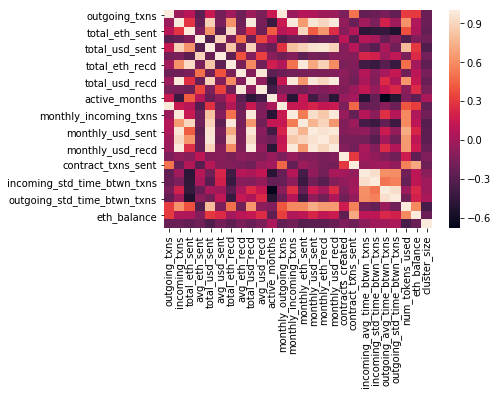

In [64]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [65]:
arr = df_summary.values

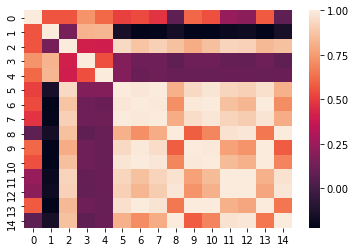

In [66]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

## Review Etherscan Labels

In [67]:
sql = '''
SELECT es.label,es.category, a.*  FROM `{}` a
INNER JOIN `{}` es
ON a.address = es.address
WHERE es.label IS NOT NULL

'''.format(table, label_table)

dflabel = client.query(sql).to_dataframe()

In [68]:
lbls = []
for i, row in dflabel.iterrows():
    lbls.append(list(df['address'].values).index(row['address']))

In [69]:
dflabel['cluster'] = [cl.labels_[i] for i in lbls]

In [70]:
# for clust in range(cl.n_clusters):
#     print('cluster {}'.format(clust))
#     print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
#     print('total points: {}'.format(np.sum(cl.labels_==clust)))
#     print(dflabel[dflabel['cluster']==clust][['label','category']])
#     print('\n\n\n')

centralization of ownership

In [71]:
total_eth = {}
total_addresses = {}

for clust in range(cl.n_clusters):
    mask = cl.labels_==clust
    eth = np.sum(df[mask]['eth_balance'])
    size = np.sum(cl.labels_==clust)
    total_eth[clust] = eth
    total_addresses[clust] = size

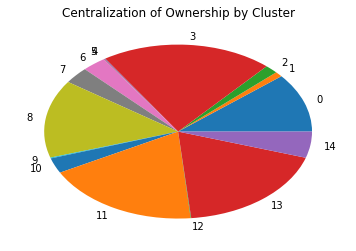

In [72]:
plt.pie(total_eth.values(), labels=total_eth.keys())
plt.title('Centralization of Ownership by Cluster')
plt.show()

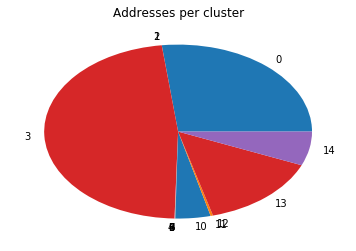

In [73]:
plt.pie(total_addresses.values(), labels=total_addresses.keys())
plt.title('Addresses per cluster')
plt.show()

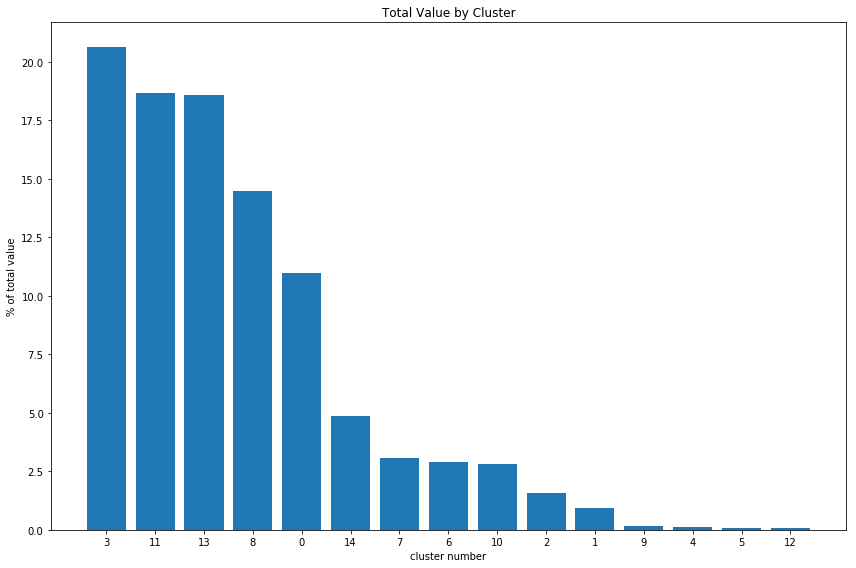

In [74]:

names = np.array(list(total_eth.keys()))
values = np.array(list(total_eth.values()))
indices = np.argsort(values)

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_eth)),values/sum(values)*100,tick_label=names)
plt.title('Total Value by Cluster')
plt.xlabel('cluster number')
plt.ylabel('% of total value')
# plt.yscale('log')
plt.tight_layout()
plt.show()




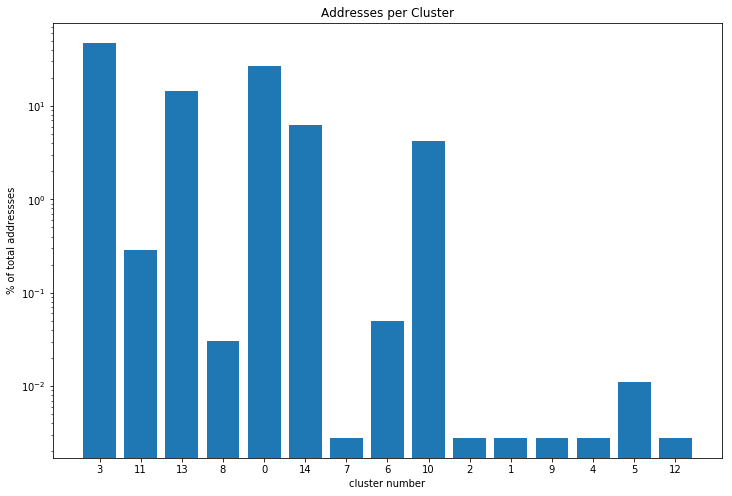

In [75]:

names = np.array(list(total_addresses.keys()))
values = np.array(list(total_addresses.values()))

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_addresses)),values/sum(values)*100,tick_label=names)
plt.title('Addresses per Cluster')
plt.yscale('log')
plt.xlabel('cluster number')
plt.ylabel('% of total addressses')
plt.show()

In [76]:


# for clust in range(cl.n_clusters):
#     cluster_data = df[cl.labels_==clust]
#     print('cluster {}'.format(clust))
#     logbins = np.logspace(0,8,16)
#     plt.hist(cluster_data['incoming_avg_time_btwn_txns'], bins=logbins)
#     plt.xscale('log')
#     plt.show()
    

In [77]:
labelresults = pipe.fit_transform(dflabel.iloc[:,3:-1])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [78]:
labelcl = KMeans(15).fit(labelresults)
dflabel['cluster'] = [labelcl.labels_[i] for i in range(len(dflabel))]

In [79]:
time_start = time.time()
tsne_label = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=20000)
tsne_results_label = tsne_label.fit_transform(labelresults)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 126 samples in 0.000s...
[t-SNE] Computed neighbors for 126 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 126 / 126
[t-SNE] Mean sigma: 0.797076
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.227463
[t-SNE] KL divergence after 850 iterations: 0.218225
t-SNE done! Time elapsed: 0.4228332042694092 seconds


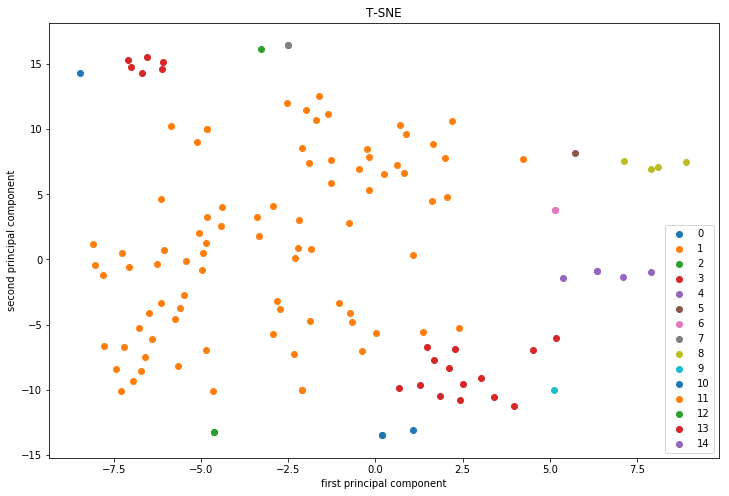

In [80]:
plt.figure(figsize=(12,8))
for c in np.unique(labelcl.labels_):
    mask = labelcl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

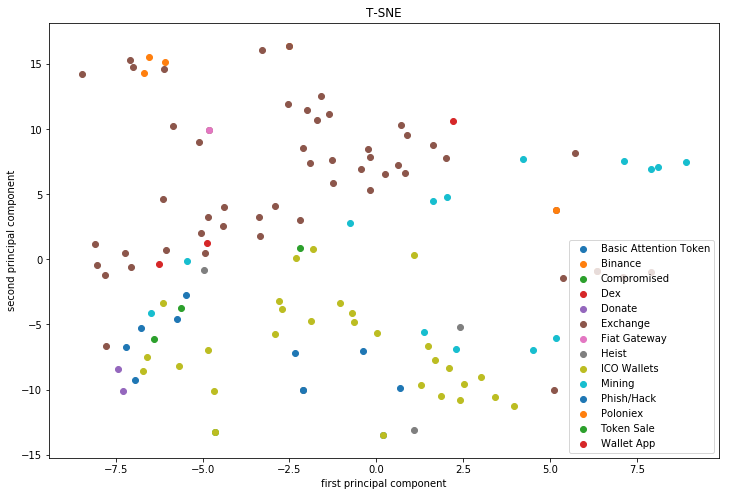

In [81]:
plt.figure(figsize=(12,8))

for c in np.unique(dflabel['category']):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

## subset original T-SNE results
create a mask for all points that are labelled

In [82]:
labeled_addresses = dflabel['address'].values
labelmask = np.array([addr in labeled_addresses for addr in df['address'] ] )

#labelmask for subset results!!!
labelmask = np.array([addr in labeled_addresses for addr in df['address'][address_mask]] )

In [83]:
#helper function for category mask
def cat(addr, labeled_addresses, dflabel):
    if addr not in labeled_addresses:
        return False
    else:
        idx = int(np.where(labeled_addresses==addr)[0][0])
        return dflabel['category'][idx]

In [93]:
#setting up color map
NUM_COLORS = len(dflabel['category'].unique())
cm = plt.get_cmap('tab20b')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if sys.path[0] == '':


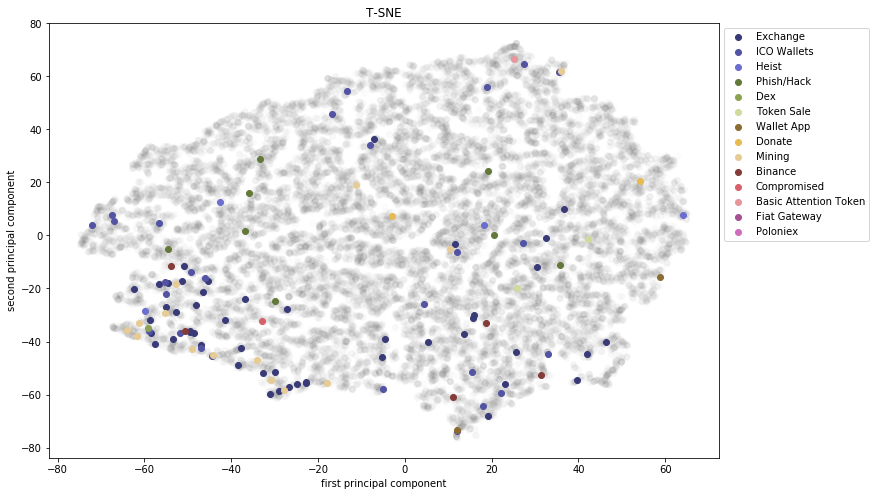

In [94]:
subset, not_subset  = tsne_results[labelmask] , tsne_results[~labelmask]
fig = plt.figure(figsize=(12,8))
#not labelled points
plt.scatter(not_subset[:,0], not_subset[:,1], c='gray', alpha=.02)

#categories
cats = np.array([cat(addr, labeled_addresses, dflabel) for addr in df['address'][address_mask] ]) #added address mask for all clusters

#labelled points

ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for c in list(dflabel['category'].unique()):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    
    #category mask
    catmask = cats == c

    plt.scatter(tsne_results[(labelmask & catmask)][:,0], tsne_results[(labelmask & catmask)][:,1], alpha=1,label=lbl)

leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

In [86]:
# for clust in range(cl.n_clusters):
#     print('cluster {}'.format(clust))
#     print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
#     print('total points: {}'.format(np.sum(cl.labels_==clust)))
#     print(dflabel[dflabel['cluster']==clust][['label', 'category']])
#     print('\n\n\n')